In [2]:

from textwrap import wrap
import shutil

import keras.utils.image_dataset
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import os, warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import random

print('TensorFlow Version ' + tf.__version__)


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


seed_everything()

import warnings

warnings.filterwarnings("ignore")

C:\Users\Admin\Documents\xkocian\VisionTrasnformer\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Admin\Documents\xkocian\VisionTrasnformer\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to enco

TensorFlow Version 2.10.0


In [3]:
image_size = 384
batch_size = 16
EPOCHS = 40

train_path = 'binary-dataset/train'
valid_path = 'binary-dataset/valid'
test_path = 'binary-dataset/test'


In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                                samplewise_center=True,
                                                                samplewise_std_normalization=True,
                                                                dtype='float16')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                               samplewise_center=True,
                                                               samplewise_std_normalization=True,
                                                               dtype='float16')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                                samplewise_center=True,
                                                                samplewise_std_normalization=True,
                                                                dtype='float16')

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode='binary',
    subset='training')

# same directory as training data

valid_gen = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=1,
    shuffle=False,
    class_mode='binary',
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=1,
    shuffle=False,
    class_mode='binary',
)
class_indices_mapping = train_gen.class_indices

Found 3148 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 713 images belonging to 2 classes.


In [5]:
from sklearn.utils import class_weight

train_labels = []
# Iterate through each batch in the generator
for i in range(len(train_gen)):
    _, labels = train_gen[i]  # Get images and labels for the current batch
    train_labels.extend(labels)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [6]:
class_weights_dict

{0: 2.3669172932330826, 1: 0.6339105920257753}

In [7]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [8]:
from vit_keras import vit

vit_model = vit.vit_b16(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=200
)

In [10]:
model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation=tf.keras.activations.gelu),
    tf.keras.layers.Dense(1, 'sigmoid')
],
    name='vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 200)               86244296  
                                                                 
 flatten_1 (Flatten)         (None, 200)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                12864     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 32)         

In [11]:
warnings.filterwarnings("ignore")

learning_rate = 1e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
filepath = "checkpoints/no-smoted-saved-model-{epoch:02d}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                                               save_best_only=False, save_weights_only=False,
                                                               mode='auto', period=1)

History = model.fit(x=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks=[early_stopping_callbacks, model_checkpoint_callback],
                    class_weight=class_weights_dict)

model.save("models/binary-model.h5")

Epoch 1/50
196/196 [==============================] - 136s 616ms/step - loss: 0.4702 - accuracy: 0.7727 - val_loss: 0.4150 - val_accuracy: 0.9635
Epoch 2/50
196/196 [==============================] - 119s 606ms/step - loss: 0.3002 - accuracy: 0.8892 - val_loss: 0.1606 - val_accuracy: 0.9792
Epoch 3/50
196/196 [==============================] - 119s 608ms/step - loss: 0.2263 - accuracy: 0.9218 - val_loss: 0.1277 - val_accuracy: 0.9688
Epoch 4/50
196/196 [==============================] - 119s 607ms/step - loss: 0.1838 - accuracy: 0.9457 - val_loss: 0.1019 - val_accuracy: 0.9688
Epoch 5/50
196/196 [==============================] - 119s 608ms/step - loss: 0.1580 - accuracy: 0.9492 - val_loss: 0.0588 - val_accuracy: 0.9844
Epoch 6/50
196/196 [==============================] - 119s 606ms/step - loss: 0.1342 - accuracy: 0.9684 - val_loss: 0.0722 - val_accuracy: 0.9792
Epoch 7/50
196/196 [==============================] - 119s 607ms/step - loss: 0.1149 - accuracy: 0.9681 - val_loss: 0.0520 -

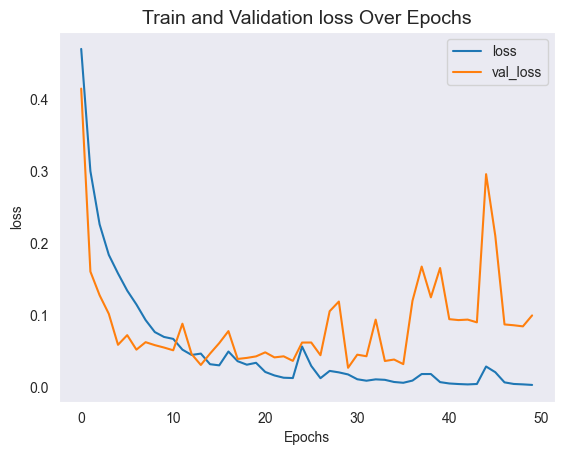

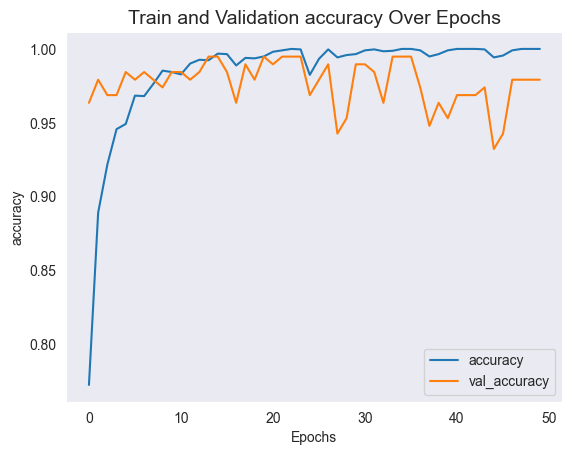

In [12]:
def plot_history(item):
    plt.plot(History.history[item], label=item)
    plt.plot(History.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

45/45 [==============================] - 12s 260ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       192
           1       0.97      0.97      0.97       521

    accuracy                           0.96       713
   macro avg       0.95      0.94      0.94       713
weighted avg       0.96      0.96      0.96       713


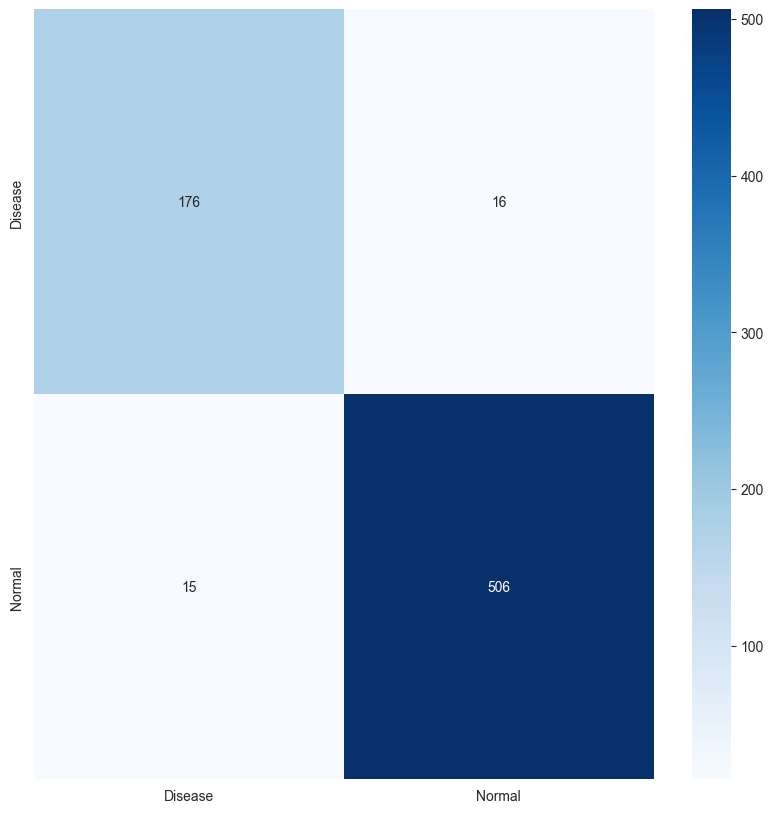

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
predictions = model.predict_generator(test_gen,steps= test_gen.n // test_gen.batch_size + 1, verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True, fmt='g', xticklabels=class_labels,
            yticklabels=class_labels)

print(classification_report(true_classes, predicted_classes))

In [35]:
import os

# Get the class names from the class indices mapping
class_names = list(class_indices_mapping.keys())

# Get the filenames of the test images
test_filenames = test_gen.filenames

# Get the true labels of the test images
true_labels = test_gen.classes

# Initialize lists to store misclassified filenames, predicted labels, and true labels
misclassified_filenames = []
misclassified_predicted_labels = []
misclassified_true_labels = []

# Iterate through each test image and compare true labels with predicted labels
for filename, true_label, predicted_label in zip(test_filenames, true_labels, predicted_classes):
    if true_label != predicted_label:
        # Reconstruct the full file path
        file_path = os.path.join(test_path, filename)
        misclassified_filenames.append(file_path)
        misclassified_predicted_labels.append(predicted_label)
        misclassified_true_labels.append(true_label)

# Print the filenames, predicted class names, true class names, predicted labels, and true labels of misclassified images
print("Misclassified Images:")
for filename, predicted_label, true_label in zip(misclassified_filenames, misclassified_predicted_labels, misclassified_true_labels):
    print("Filename:", filename)
    print("Predicted Class:", class_names[int(predicted_label)])
    print("True Class:", class_names[int(true_label)])
    print()


Misclassified Images:
Filename: binary-dataset/test\Disease\152_right.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\168_right.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\1854_left.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\1857_right.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\1874_right.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\1878_right.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\410_right.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\424_right.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\532_left.jpg
Predicted Class: Normal
True Class: Disease

Filename: binary-dataset/test\Disease\608_left.jpg
Predicted Class: Normal
True Class: Disease

Filenam

In [ ]:
from vit_keras import vit, utils, visualize
for filename in misclassified_filenames:
    # Read the image
    image = utils.read(filename, image_size)
    
    # Get attention map
    attention_map = visualize.attention_map(model=model.layers[0], image=image)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(attention_map)
    
    plt.show()  # Show the plot for each image